In [1]:
## Importing needed packages and functions for model

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
import neptune

pl.seed_everything(2023)


/Users/adamwalker/opt/anaconda3/envs/Deep_Learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 2023


2023

In [2]:
## Importing packages for visualization

from misc_functions import get_example_params, save_class_activation_images, preprocess_image
from PIL import Image


In [3]:
## Loading data
labels_df = pd.read_csv('train_labels.csv')

In [88]:
## Adding the same model architecture

## Creating the model

class HistopathClassifier(pl.LightningModule):
    def __init__(self):
        super(HistopathClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.25)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)
    
    def train_step(self, inputs, labels, criterion, optimizer):
        optimizer.zero_grad()
        outputs = self(inputs).squeeze()
        
        if outputs.squeeze().dim() == 0: #done for rare instances where a batch could have only 1 sample
            outputs = outputs.unsqueeze(0)
    
        #print(outputs.shape)
        #print(outputs.squeeze().shape)
        #print(labels.float().shape)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        return loss.item()

    def validate_step(self, inputs, labels, criterion):
        with torch.no_grad():
            outputs = self(inputs).squeeze()
            if outputs.squeeze().dim() == 0: #done for rare instances where a batch could have only 1 sample
                outputs = outputs.unsqueeze(0)
            
            loss = criterion(outputs, labels.float())
        return loss.item()



In [94]:
## Double checking it looks the same

## Creating the model and getting a summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_epochs = 20
model = HistopathClassifier()
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


summary(model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
           Dropout-7                 [-1, 9216]               0
            Linear-8                  [-1, 512]       4,719,104
           Dropout-9                  [-1, 512]               0
           Linear-10                    [-1, 1]             513
          Sigmoid-11                    [-1, 1]               0
Total params: 4,743,201
Trainable params: 4,743,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forw

In [95]:
## Loading from weights trained on the main script

model.load_state_dict(torch.load("my_model.pt",map_location=torch.device('cpu')))


<All keys matched successfully>

In [7]:
from torchvision import models

pretrained_model = models.alexnet(pretrained=True)

In [92]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=64 * 12 * 12, out_features=512, bias=True),
            nn.ReLU(),

            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64 * 12 * 12)
        x = self.fc_layers(x)
        return x

fake_model = MyModel()
print(fake_model._modules['conv_layers'])
#print(fake_model.fc_layers)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [30]:

model._modules


OrderedDict([('conv1',
              Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('conv2',
              Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('conv3',
              Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('pool',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('fc1', Linear(in_features=9216, out_features=512, bias=True)),
             ('fc2', Linear(in_features=512, out_features=1, bias=True)),
             ('dropout', Dropout(p=0.25, inplace=False)),
             ('sigmoid', Sigmoid()),
             ('loss', BCELoss())])

In [21]:
pretrained_model._modules['features']
#pretrained_model._modules['classifier']

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [22]:
## Attempting LRP on a single iamge 
from LRP import LRP

input_images_list = os.listdir("input_images")

img = input_images_list[0]
path_to_image = os.path.join("input_images", img)

original_image = Image.open(path_to_image).convert('RGB')
prep_img = preprocess_image(original_image)

layerwise_relevance = LRP(fake_model)

LRP_per_layer = layerwise_relevance.generate(prep_img, 0)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50176 and 9216x512)

In [116]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import matplotlib.pyplot as plt


# Preprocess images to standardize them
def preprocess_image(img):
    # Resize and normalize the image
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(img)

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.model.pool(F.relu(self.model.conv1(x)))
        x = self.model.pool(F.relu(self.model.conv2(x)))
        x = self.model.pool(F.relu(self.model.conv3(x)))
        return x

    def generate_cam(self, input_image):
        # Forward pass
        conv_output = self.forward(input_image)

        # Set up hooks for gradients
        conv_output.register_hook(self.save_gradient)

        # Compute gradients with respect to the target class
        conv_output.backward(torch.ones_like(conv_output))

        # Normalize gradients
        gradients = self.gradients.detach().cpu().numpy()
        gradients = gradients - gradients.min()
        gradients = gradients / gradients.max()

        # Global average pooling of gradients
        pooled_gradients = np.mean(gradients, axis=(2, 3))[0]

        # Weighted sum of feature maps and gradients
        activations = conv_output.detach().cpu().numpy()[0]
        cam = np.zeros_like(activations[0])

        for i, w in enumerate(pooled_gradients):
            cam += w * activations[i]

        # Normalize and resize CAM
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        cam = cv2.resize(cam, (96, 96))
        
        return cam


# Load images and preprocess
input_images_list = os.listdir("input_images")

img = input_images_list[1]
path_to_image = os.path.join("input_images", img)
original_image = Image.open(path_to_image).convert('RGB')
preprocessed_image = preprocess_image(original_image)

# 5. Generate Grad-CAM visualization for the image
grad_cam = GradCAM(model)
cam = grad_cam.generate_cam(preprocessed_image)

# Plot the Grad-CAM visualization
plt.imshow(original_image.resize((96, 96)), alpha=0.1)
plt.imshow(cam, cmap='inferno', alpha=1)
plt.show()

/var/folders/58/n1b_39s143b56923sxy6dwn00000gn/T/ipykernel_6825/452925583.py:46: RuntimeWarning: invalid value encountered in divide
  gradients = gradients / gradients.max()


AxisError: axis 3 is out of bounds for array of dimension 3

/Users/adamwalker/opt/anaconda3/envs/Deep_Learning/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/var/folders/58/n1b_39s143b56923sxy6dwn00000gn/T/ipykernel_6825/2529934519.py:40: RuntimeWarning: invalid value encountered in divide
  gradients = gradients / gradients.max()


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

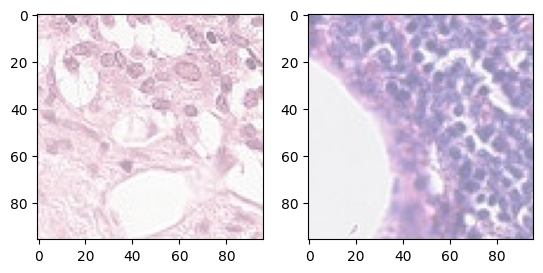

In [44]:
# 2. Define a function to preprocess a list of input images
def preprocess_images(images):
    # Resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor()
        ])
    return torch.stack([transform(img) for img in images])

# 3. Update the Grad-CAM class to handle batched input
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.model.pool(F.relu(self.model.conv1(x)))
        x = self.model.pool(F.relu(self.model.conv2(x)))
        x = self.model.pool(F.relu(self.model.conv3(x)))
        return x

    def generate_cam(self, input_images):
        # Forward pass
        conv_output = self.forward(input_images)
        print(conv_output)

        # Set up hooks for gradients
        conv_output.register_hook(self.save_gradient)

        # Compute gradients with respect to the target class
        conv_output.backward(torch.ones_like(conv_output))

        # Normalize gradients
        gradients = self.gradients.detach().cpu().numpy()
        gradients = gradients - gradients.min()
        gradients = gradients / gradients.max()

        # Global average pooling of gradients
        pooled_gradients = np.mean(gradients, axis=(2, 3))

        # Weighted sum of feature maps and gradients
        activations = conv_output.detach().cpu().numpy()
        cam_batch = []

        for b in range(activations.shape[0]):
            cam = np.zeros_like(activations[b, 0])

            for i, w in enumerate(pooled_gradients[b]):
                cam += w * activations[b, i]

            # Normalize and resize CAM
            cam = np.maximum(cam, 0)
            cam = cam / cam.max()
            cam = cv2.resize(cam, (96, 96))
            cam_batch.append(cam)

        return cam_batch


# Load images and preprocess
input_images_list = os.listdir("input_images")

img = input_images_list[1]
path_to_image = os.path.join("input_images", img)
original_image1 = Image.open(path_to_image).convert('RGB')

img2 = input_images_list[2]
path_to_image2 = os.path.join("input_images", img2)
original_image2 = Image.open(path_to_image2).convert('RGB')


# 4. Load a batch of example images and preprocess them
input_images = [original_image1, original_image2]
preprocessed_images = preprocess_images(input_images)

# 5. Generate Grad-CAM visualizations for the images
grad_cam = GradCAM(model)
cams = grad_cam.generate_cam(preprocessed_images)

# Plot the Grad-CAM visualizations for each image
for i in range(len(input_images)):
    plt.subplot(1, len(input_images), i+1)
    plt.imshow(input_images[i].resize((96, 96)), alpha=0.5)
    plt.imshow(cams[i], cmap='jet', alpha=1)

plt.show()

In [59]:
!pip install --upgrade scikit-learn

5287.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.0
    Uninstalling scikit-learn-1.1.0:
      Successfully uninstalled scikit-learn-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
omnixai 1.2.5 requires scikit-learn<1.2,>=0.24, but you have scikit-learn 1.2.2 which is incompatible.


In [61]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from torchvision.models import resnet50

res_model = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/adamwalker/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.9MB/s]


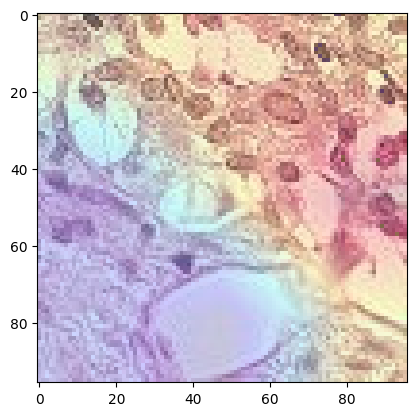

In [87]:
target_layers= [res_model.layer4[-1]]

input_tensor = preprocessed_images[0].unsqueeze(0)
normalized_image = (input_tensor.numpy().astype(np.float32) / 255.0).squeeze()
normalized_image_transposed = normalized_image.transpose(1,2,0)

cam = GradCAM(model=res_model, target_layers=target_layers)

targets = [ClassifierOutputTarget(281)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(normalized_image_transposed, grayscale_cam, use_rgb=True)

original_image = Image.open(path_to_image).convert('RGB')

plt.imshow(original_image, alpha=0.9)
plt.imshow(visualization, cmap='inferno', alpha=.2)
plt.show()

In [117]:
target_layers = [model._modules['conv1'], model._modules['conv2'], model._modules['conv3']]

input_tensor = preprocessed_images[0].unsqueeze(0)
normalized_image = (input_tensor.numpy().astype(np.float32) / 255.0).squeeze()
normalized_image_transposed = normalized_image.transpose(1,2,0)

cam = GradCAM(model=model, target_layers=target_layers)

new_cam = cam(input_tensor=input_tensor)
new_cam = new_cam[0,:]

img = input_images_list[1]
path_to_image = os.path.join("input_images", img)

original_image = Image.open(path_to_image).convert('RGB')

plt.imshow(original_image, alpha=1)
plt.imshow(new_cam, cmap='jet', alpha=.3)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'target_layers'